In [ ]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
# import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
# from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision.transforms.functional as TF

#torchio
import torchio as tio

In [2]:
# class indices

LARGE_BOWEL = 0
SMALL_BOWEL = 1
STOMACH = 2
MASK_INDICES = {'large_bowel': LARGE_BOWEL, 'small_bowel':SMALL_BOWEL, 'stomach':STOMACH}
DATA_SIZE = 219

In [3]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    train_bs      = 1
    valid_bs      = 1
    image_size    = [128, 128, 128] # Depth, Width, Height
    whf_pool_size = 4
    epochs        = 128
    lr            = 2e-6 # 0.00001 # 2e-4 # 2e-3
    scheduler     = 'CosineAnnealingLR'
    warmup_epochs = 0
    wd            = 1e-3
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    min_lr        = 1e-6
    T_max         = int(DATA_SIZE/train_bs/n_accumulate*epochs)+50
    T_0           = 25
    drop_rate = 0.01

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [5]:
def load_scans(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f))]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices)
    max_val = np.max(img)
    if max_val:
        img /= max_val

    return img

def load_mask(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Dataset

In [6]:
def plot_batch(imgs, msks, depth, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx, depth].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx, depthm].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [7]:
set_dimension_order_to_c_z_x_y = tio.Lambda(lambda x: torch.permute(x,(0,3,1,2)), types_to_apply=[tio.INTENSITY, tio.LABEL])

data_transforms = {
    "train": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'), 
         tio.RandomFlip(axes=(0,1), p=0.2), 
         tio.RandomAffine(scales=(0.9, 1.2), degrees=15, p=0.2), 
         tio.OneOf([tio.RandomElasticDeformation(), tio.RandomMotion()], p=0.3), 
         tio.OneOf([tio.RandomGhosting(), tio.RandomSpike(), tio.RandomBlur()], p=0.3),
         # set_dimension_order_to_c_z_x_y
        ]
    ),
    "valid": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'),
         # set_dimension_order_to_c_z_x_y
        ]
    )
}

In [8]:
class ResizedSubject(tio.Subject):
    def load(self):
        super(ResizedSubject, self).load()
        self['original_size'] = list(self['scan'][tio.DATA].shape)[1:]
    

In [9]:
def scan_reader(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f)) and f.endswith('.png')]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = np.expand_dims(scan_slice, axis=0)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices, axis=-1)

    return img, None

def mask_reader(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask, None

def get_subject(case_day, scan_path, mask_path=None):
    
    if not mask_path:
        return ResizeSubject(
            case_day=case_day, 
            scan=tio.ScalarImage(path=scan_path, reader=scan_reader),
        )

    return ResizedSubject(
        case_day=case_day,
        scan=tio.ScalarImage(path=scan_path, reader=scan_reader),
        label=tio.LabelMap(path=mask_path, reader=mask_reader),
    )

In [10]:
# function for assigning fold to Data frame rows

def assign_fold_to_df(df, num_folds=5):
    num_rows = len(df)
    folds = np.zeros(num_rows, dtype='uint8')
    fold_vals = [i for i in range(num_folds)]
    indices = [i for i in range(num_rows)]
    random.shuffle(indices)
    random.shuffle(fold_vals)
    for i in indices:
        folds[i] = fold_vals[i % num_folds]

     # not shuffling fold_vals will cause some fold indices to always get less number of items than other fold indices.
    # EX: number of items is 2, and num_folds = 3. Assigning fold index with order [0,1,2] will make only fold-0 and fold-1 get an item, while fold-2 has 0 item.
 
    df['fold'] = folds

In [11]:
def prepare_loaders(df, fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    train_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in train_df.iterrows()], 
        transform=data_transforms['train']
    )
    valid_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in valid_df.iterrows()], 
        transform=data_transforms['train']
    )

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 1, 
                              num_workers=4, shuffle=True, pin_memory=False, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 1, 
                              num_workers=4, shuffle=False, pin_memory=False)
    
    return train_loader, valid_loader

In [12]:
# Load data frame

df_train = pd.read_csv('./input/uw-madison-gi-tract-image-segmentation/train.csv')
train_path = './input/uw-madison-gi-tract-image-segmentation/train'
df_train['case_day'] = df_train['id'].map(lambda x: x.split('_slice')[0])
df_train.drop(columns=['class', 'segmentation', 'id'], inplace=True)
df_train.drop_duplicates(inplace=True)
df_train['image_path'] = df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/scans')
df_train['mask_path'] =  df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/masks3D/{x}.npy')
assign_fold_to_df(df_train)
df_train.head(4)

,case_day,image_path,mask_path,fold
0,case123_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,1
432,case123_day22,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,2
864,case123_day0,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,0
1296,case77_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,3


### Compare with Transformed Data

Create Dataset and compare with the transformed image.\
You may want to temporaruily remove any spatial transformation that moves the original data along z-axis, \
because bellow code compares image with fixed slice number(z-axis value).

Skip bellow section, if you are done dataset debugging

In [13]:
import glob

In [14]:
subject_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in df_train.iterrows()], 
        transform=data_transforms['train']
    )

In [15]:
# Select a subject
# By selecting an item with indexing, data transformation is perofrmed in bellow code.
# It will be performed again if you execute bellow code again even with the same index value.
subject = subject_dataset[3]

In [16]:
slice_num = 113 # z-axis value
case_day = subject['case_day']
original_size = subject['original_size']
case_day, original_size

('case77_day20', [266, 266, 144])

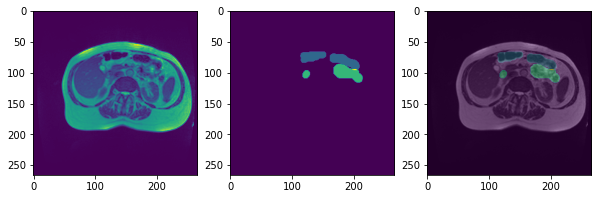

array([1277., 1960.,    0.], dtype=float32)

In [17]:
# Show the original image

df_row = df_train.loc[df_train['case_day'] == case_day].iloc[0]
image_path = glob.glob(df_row['image_path'] + f'/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
mask = load_mask(df_row['mask_path'])[:, :, :, slice_num-1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

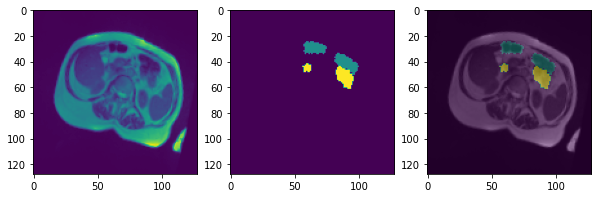

tensor([302., 392.,   0.])

In [18]:
# Show trnsformed image
resized_slice_num = slice_num * CFG.image_size[2] // len(glob.glob(df_row['image_path'] + f'/slice_*.png')) 
image = subject['scan'][tio.DATA][0][:,:, resized_slice_num -1]
mask = subject['label'][tio.DATA][:,:,:, resized_slice_num - 1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

# Build Model

### Cycle shift

In [19]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        # x.shape (b, 56, 56, 96)
        return torch.roll(x, shifts=(self.displacement, self.displacement, self.displacement), dims=(1, 2, 3))

### Skip Connection & Layer Normalization

In [20]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

### MLP

In [21]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        return self.net(x)

### Attetion Mask

In [22]:
# expects a tensor that has same shape as the window, and have values 1 or -1 only
def _get_mask_from_bipartitioned_window(window_partition):
    # flatten the window with partitioned value
    window_partition = window_partition.view(-1)

    # tensor with size (window_size ** 3, window_size ** 3), where each value corresponds to a pair of points in the window
    # if the point pair is in the same partition, it will have value 1, and -1 otherwise.
    mask_base = (window_partition[:, None] @ window_partition[None,: ])

    # change value -1 to 0, and 1 to 2
    mask_base +=1
    # covert value 0 to nan and 1 to negative infinity
    mask_base *= -float('inf')
    
    # mask_base = (window_partition[:, None] @ window_partition[None,: ]) : tensor of (window_size ** 3, window_size ** 3, with value 1 or -1
    # mask_base += 1 :converts value -1 to 0, and value 1 to 2
    # mask_base *= float('-inf') : converts value 0 to nan and value 2 to negative infinity
    # mask_base *= 2 : tensor of (window_size ** 3, window_size ** 3, with value 2 or 0
    mask_base = ((window_partition[:, None] @ window_partition[None,: ]) + 1) * float('-inf') 

    # mask = torch.nan_to_num(mask_base) : converts nan value to zero, and netative infinity value to the lowest value of float data type 
    # mask *= 2 : converts lowest value back to negative infinity 
    return torch.nan_to_num(mask_base) * 2

def create_mask(window_size, displacement, left_right, upper_lower, front_back):
    # assume spatial dimension has (order, width, height, depth)
    
    # masked positions will have value negative infinite
    # unmasked positions will have value zero
    mask = torch.zeros(window_size ** 3, window_size ** 3)
    
    if left_right:
        window_partition = torch.zeros(window_size, window_size, window_size)
        # partition window by value -1 and 1 
        window_partition[:-displacement] = 1
        window_partition[-displacement:] = -1
        
        mask += _get_mask_from_bipartitioned_window(window_partition)
    
    if upper_lower:
        window_partition = torch.zeros(window_size, window_size, window_size)
        # partition window by value -1 and 1 
        window_partition[:, :-displacement] = 1
        window_partition[:, -displacement:] = -1
        
        mask += _get_mask_from_bipartitioned_window(window_partition)
        
    if front_back:
        window_partition = torch.zeros(window_size, window_size, window_size)
        # partition window by value -1 and 1 
        window_partition[:, :, :-displacement] = 1
        window_partition[:, :, -displacement:] = -1
        
        mask += _get_mask_from_bipartitioned_window(window_partition)

    return mask

### W-MSA & SW-MSA

In [23]:
def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y, z] for x in range(window_size) for y in range(window_size) for z in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding=True, attention_drop=0.0, output_drop=0.0):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted
        
        self.attention_drop = nn.Dropout(attention_drop)
        self.output_drop = nn.Dropout(output_drop)

        if self.shifted:
            displacement = window_size // 2  # 7//2 = 3
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(
                create_mask(
                    window_size=window_size, 
                    displacement=displacement, 
                    upper_lower=True, 
                    left_right=False, 
                    front_back=False
                ), 
                requires_grad=False
            )
            self.left_right_mask = nn.Parameter(
                create_mask(
                    window_size=window_size, 
                    displacement=displacement, 
                    upper_lower=False, 
                    left_right=True, 
                    front_back=False
                ), 
                requires_grad=False
            )
            self.front_back_mask = nn.Parameter(
                create_mask(
                    window_size=window_size, 
                    displacement=displacement, 
                    upper_lower=False, 
                    left_right=False, 
                    front_back=True
                ), 
                requires_grad=False
            )
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            #  + window_size - 1 is for removing negative values
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1, 2 * window_size - 1))
            
            # EX window size is 4, query has postion (1, 1, 1) and key has position (1, 1, 1)
            # then query -> key has relative distance (3, 3, 3) = (0, 0, 0) + (window size -1)
            # query (0, 0, 0),  key (3, 3, 3)
            # then query -> key relative distance = (6, 6, 6) = (3, 3, 3) + (4 - 1)
            # query (3, 3, 3), key (0, 0, 0)
            # then query -> key relative distance = (0, 0, 0) = (-3, -3, -3) + (4 - 1)
            
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 3, window_size ** 3))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        batch_size, width, height, depth, _ = x.shape

        qkv = self.to_qkv(x).chunk(3, dim=-1)  # (b, 56, 56, 56, 288) -> tuple len 3 (b, 56, 56, 56, 96)
        nw_h = height // self.window_size  # 8
        nw_w = width // self.window_size  # 8
        nw_d = depth // self.window_size  # 8
        
        # 'b (nw_w w_w) (nw_h w_h) (nw_d w_d) (h d) -> b h (nw_w nw_h nw_d) (w_w w_h w_d) d'
        q, k, v = map(
            lambda t: t.view(
                batch_size, nw_w, self.window_size, nw_h, self.window_size, nw_d, self.window_size, self.heads, -1
            ).permute(0, 8, 1, 3, 5, 2, 4, 6, 7).reshape(batch_size, self.heads, nw_w * nw_h * nw_d, self.window_size ** 3, -1), 
            qkv
        ) 


        # (b, 3, 8 ** 3, 7 ** 3, 32), (b, 3, 8 ** 3, 7 ** 3, 32)  -> (b, 3, 8 ** 3, 7 ** 3, 7 ** 3)
        dots = torch.einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[
                self.relative_indices[:, :, 0].type(torch.long), 
                self.relative_indices[:, :, 1].type(torch.long), 
                self.relative_indices[:, :, 2].type(torch.long)
            ]  # (7 **3, 7 **3)
        else:
            dots += self.pos_embedding

        if self.shifted:  # masking
            dots = dots.view(batch_size, self.heads, nw_w, nw_h, nw_d, self.window_size ** 3, self.window_size **3)
            dots[:, :, -1] += self.left_right_mask
            dots[:, :, :, -1] += self.upper_lower_mask
            dots[:, :, :, :, -1] += self.front_back_mask
            dots = dots.view(batch_size, self.heads, -1, self.window_size ** 3, self.window_size **3)

        attn = dots.softmax(dim=-1)
        attn = self.attention_drop(attn)  # forgot
        out = torch.einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        
        # 'b h (w_h w_w) (nw_w nw_h nw_d) (w_w w_h w_d) d -> b (nw_w w_w) (nw_h w_h) (nw_d w_d) (h d)
        out = out.view(
            batch_size, self.heads, nw_w, nw_h, nw_d, self.window_size, self.window_size, self.window_size, -1
        ).permute(
            (0, 2, 5, 3, 6, 4, 7, 1, 8)
        ).reshape(
            batch_size, nw_w * self.window_size, nw_h * self.window_size, nw_d * self.window_size, -1
        )
                        
        out = self.to_out(out)
        out = self.output_drop(out)  # forgot

        if self.shifted:
            out = self.cyclic_back_shift(out)  # return back shifted value
        return out

### Swin Transformer Block

In [24]:
class SwinBlock(nn.Module):
    def __init__(
        self, 
        dim, 
        heads, 
        head_dim, 
        mlp_dim, 
        shifted, 
        window_size, 
        relative_pos_embedding=True,
        attention_drop_rate=0.0,
        wa_output_drop_rate=0.0,
        ff_drop_rate=0.0
    ):
        super().__init__()
        self.attention_block = Residual(
            PreNorm(
                dim, 
                WindowAttention(
                    dim=dim,
                    heads=heads,
                    head_dim=head_dim,
                    shifted=shifted,
                    window_size=window_size,
                    relative_pos_embedding=relative_pos_embedding, 
                    attention_drop= attention_drop_rate, 
                    output_drop=wa_output_drop_rate
                )
            )
        )
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim, drop=ff_drop_rate)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

### Patch Partition or Patch Merging & Linear Embedding

In [25]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 3, out_channels)

    def forward(self, x):
        b, c, w, h, d = x.shape
        new_w, new_h, new_d = w // self.downscaling_factor, h // self.downscaling_factor, d // self.downscaling_factor  #  num patches along width, height, depth
        x = x.view(b, c, new_w, self.downscaling_factor, new_h, self.downscaling_factor, new_d, self.downscaling_factor).permute(0, 2, 4, 6, 3, 5, 7, 1).reshape(b, new_w, new_h, new_d, -1)
        return self.linear(x)  # (b, 56, 56, 56, 192) -> (b, 56, 56, 56, out_channels)

### StageModule

In [26]:
class StageModule(nn.Module):
    def __init__(
        self, 
        in_channels, 
        hidden_dimension, 
        layers, 
        downscaling_factor, 
        num_heads, 
        head_dim, 
        window_size,
        relative_pos_embedding=True,
        attention_drop_rate=0.0,
        wa_output_drop_rate=0.0,
        ff_drop_rate=0.0
    ):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(
                nn.ModuleList(
                    [SwinBlock(
                        dim=in_channels, 
                        heads=num_heads, 
                        head_dim=head_dim, 
                        mlp_dim=in_channels * 4,
                        shifted=False, 
                        window_size=window_size, 
                        relative_pos_embedding=relative_pos_embedding,
                        attention_drop_rate=attention_drop_rate, 
                        wa_output_drop_rate=wa_output_drop_rate, 
                        ff_drop_rate=ff_drop_rate
                    ), 
                     SwinBlock(
                         dim=in_channels, 
                         heads=num_heads, 
                         head_dim=head_dim, 
                         mlp_dim=in_channels * 4, 
                         shifted=True, 
                         window_size=window_size, 
                         relative_pos_embedding=relative_pos_embedding,
                         attention_drop_rate=attention_drop_rate, 
                         wa_output_drop_rate=wa_output_drop_rate, 
                         ff_drop_rate=ff_drop_rate
                     )]
                )
            )

        self.patch_partition = PatchMerging(
            in_channels=in_channels, 
            out_channels=hidden_dimension, 
            downscaling_factor=downscaling_factor
        )
    def forward(self, x):
        
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        
        x = x.permute(0, 4, 1, 2, 3) # (4, 56, 56, 56, 96) -> (4, 96, 56, 56, 56)
        return self.patch_partition(x)

In [27]:
def double_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.InstanceNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.InstanceNorm3d(out_channels),
        nn.ReLU(inplace=True),
    )

class SwinTransformerUNet3D(nn.Module):
    def __init__(
        self, 
        hidden_dim=48, 
        heads=(3,3,3,3), 
        channels=1, 
        num_classes=3, 
        head_dim=32, 
        window_size=4, 
        layers=(2, 2, 2, 2), 
        downscaling_factors=(2, 2, 2, 2, 2), 
        relative_pos_embedding=True,
        up_drop_rate=0.0,
        attention_drop_rate=0.0,
        wa_output_drop_rate=0.0,
        ff_drop_rate=0.0
    ):
        super().__init__()
        self.patch_partition = PatchMerging(
            in_channels=channels, 
            out_channels=hidden_dim, 
            downscaling_factor=downscaling_factors[0]
        )
        self.stage1 = StageModule(
            in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[0], 
            downscaling_factor=downscaling_factors[1], num_heads=heads[0], head_dim=head_dim, 
            window_size=window_size, relative_pos_embedding=relative_pos_embedding,
            attention_drop_rate=attention_drop_rate, wa_output_drop_rate=wa_output_drop_rate, ff_drop_rate=ff_drop_rate
        )
        # input shape
        self.stage2 = StageModule(
            in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[1],
            downscaling_factor=downscaling_factors[2], num_heads=heads[1], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding,
            attention_drop_rate=attention_drop_rate, wa_output_drop_rate=wa_output_drop_rate, ff_drop_rate=ff_drop_rate
        )

        self.stage3 = StageModule(
            in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[2],
            downscaling_factor=downscaling_factors[3], num_heads=heads[2], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding,
            attention_drop_rate=attention_drop_rate, wa_output_drop_rate=wa_output_drop_rate, ff_drop_rate=ff_drop_rate
        )

        self.stage4 = StageModule(
            in_channels=hidden_dim * 8, hidden_dimension=hidden_dim * 16, layers=layers[3],
            downscaling_factor=downscaling_factors[4], num_heads=heads[3], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding,
            attention_drop_rate=attention_drop_rate, wa_output_drop_rate=wa_output_drop_rate, ff_drop_rate=ff_drop_rate
        )
        
        self.stage4_up = nn.ModuleList(
            [double_conv_block(hidden_dim * 16, hidden_dim * 16), 
             nn.ConvTranspose3d(hidden_dim * 16, hidden_dim * 8, kernel_size=2, stride=2)]
        )
        
        self.stage3_up = nn.ModuleList(
            [double_conv_block(hidden_dim * 8, hidden_dim * 8), 
             nn.Dropout(up_drop_rate),
             double_conv_block(hidden_dim * 16, hidden_dim * 8), 
             nn.ConvTranspose3d(hidden_dim * 8, hidden_dim * 4, kernel_size=2, stride=2)]
        )
        
        self.stage2_up = nn.ModuleList(
            [double_conv_block(hidden_dim * 4, hidden_dim * 4), 
             nn.Dropout(up_drop_rate),
             double_conv_block(hidden_dim * 8, hidden_dim * 4), 
             nn.ConvTranspose3d(hidden_dim * 4, hidden_dim * 2, kernel_size=2, stride=2)]
        )
        
        self.stage1_up = nn.ModuleList(
            [double_conv_block(hidden_dim * 2, hidden_dim * 2), 
             nn.Dropout(up_drop_rate),
             double_conv_block(hidden_dim * 4, hidden_dim * 2), 
             nn.ConvTranspose3d(hidden_dim * 2, hidden_dim, kernel_size=2, stride=2)]
        )
        self.final_up = nn.ModuleList(
            [double_conv_block(hidden_dim, hidden_dim), 
             nn.Dropout(up_drop_rate),
             double_conv_block(hidden_dim * 2, hidden_dim), 
             nn.ConvTranspose3d(hidden_dim, hidden_dim, kernel_size=2, stride=2)]
        )
        
        self.image_size_blocks = nn.ModuleList(
            [nn.Linear(channels, hidden_dim), double_conv_block(hidden_dim * 2, hidden_dim)]
        )

        self.final_conv = nn.Sequential(nn.Conv3d(hidden_dim, num_classes, kernel_size=1),  nn.Sigmoid())

    def forward(self, img):
        # width, height, and depth, each should be divisible by product of downscaling factors and window size 
        # (width, height, or deapth) % (np.prod(downscaling factors) * window_size) == 0
        
        # image shape(b, 3, 128, 128, 128) 
        x0 = self.patch_partition(img)  # (b, 64, 64, 64, 48)
        x1 = self.stage1(x0)  # (b, 32, 32, 32, 96)
        x2 = self.stage2(x1)  # (b, 16, 16, 16, 192)
        x3 = self.stage3(x2)  # (b, 8, 8, 8, 384)
        x4 = self.stage4(x3)  # (b, 4, 4, 4, 768)
        
        x = self.stage4_up[0](x4.permute(0, 4, 1, 2, 3))  # double conv block (b, 768, 4, 4, 4)
        x = self.stage4_up[1](x)   # transposed convolution to increase spatial size (b, 384, 8, 8, 8)
        
        x = self.stage3_up[0](x)  # double conv block (b, 384, 8, 8, 8)
        x = torch.cat((x, x3.permute(0, 4, 1, 2, 3)), dim=1)   # (b, 768, 8, 8, 8)
        x = self.stage3_up[1](x)  # dropout
        x = self.stage3_up[2](x)  # double conv block with skip connection (b, 384, 8, 8, 8)
        x = self.stage3_up[3](x)  # transposed convolution to increase spatial size (b, 192, 16, 16, 16)
        
        x = self.stage2_up[0](x)  # double conv block (b, 192, 16, 16, 16)
        x = torch.cat((x, x2.permute(0, 4, 1, 2, 3)), dim=1)   # (b, 384, 16, 16, 16)
        x = self.stage2_up[1](x)  # dropout
        x = self.stage2_up[2](x)  # double conv block with skip connection (b, 192, 16, 16, 16)
        x = self.stage2_up[3](x)  # transposed convolution to increase spatial size (b, 96, 32, 32, 32)
        
        x = self.stage1_up[0](x)  # double conv block (b, 96, 32, 32, 32)
        x = torch.cat((x, x1.permute(0, 4, 1, 2, 3)), dim=1)  # (b, 192, 32, 32, 32)
        x = self.stage1_up[1](x)  # dropout
        x = self.stage1_up[2](x)  # double conv block with skip connection (b, 96, 32, 32, 32)
        x = self.stage1_up[3](x)  # transposed convolution to increase spatial size (b, 48, 64, 64, 64)
        
        x = self.final_up[0](x)    # double conv block (b, 48, 64, 64, 64)
        x = torch.cat((x, x0.permute(0, 4, 1, 2, 3)), dim=1)   # (b, 96, 64, 64, 64)
        x = self.final_up[1](x)  # dropout
        x = self.final_up[2](x)  # transposed convolution to increase spatial size (b, 48, 64, 64, 64)
        x = self.final_up[3](x)  # transposed convolution to increase spatial size (b, 48, 128, 128, 128)
        
        image_embedded = self.image_size_blocks[0](img.permute(0, 2, 3, 4, 1)).permute(0, 4, 1, 2 ,3)   # (b, 48, 128, 128, 128)
        x = torch.cat((x, image_embedded), dim=1)   # (b, 96, 128, 128, 128)
        x = self.image_size_blocks[1](x)   # (b, 48, 128, 128, 128)
        
        return self.final_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features =[64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        #down part of UNet
        for feature in features:
            self.downs.append(double_conv_block(in_channels, feature))
            in_channels = feature

        #upsample part of UNet
        for feature in reversed(features):
            self.ups.append(
              nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(double_conv_block(feature*2, feature))

        self.bottleneck = double_conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Sequential(nn.Conv3d(features[0], out_channels, kernel_size=1),  nn.Sigmoid())

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)


        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # if x.shape != skip_connection.shape:
            #     x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [28]:
def build_model():
    model = SwinTransformerUNet3D(
        up_drop_rate=CFG.drop_rate,
        attention_drop_rate=CFG.drop_rate,
        wa_output_drop_rate=CFG.drop_rate,
        ff_drop_rate=CFG.drop_rate
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Loss

In [29]:
def get_segmtation_indices(mask):
    """
    :mask: (C x W x H x D) Tensor of the probability map of the estimation.
    :return: List of List of Tensors of the Ground Truth points.
                   The outer most list must be of size B as in prob_map.
                   The second outer most list must be of size C.
                   Each element in the second outer most list must be a 2D Tensor,
                   where each row is the (x, y, z), i.e, (col, row, depth) of a GT point.
    """
    num_classes = mask.size()[0]
    mask_indices = []
    for i in range(num_classes):
        mask_indices.append((mask[i] > 0).nonzero())
    
    return mask_indices


def _assert_no_grad(variables_list):
    for variables in variables_list:
        for var in variables:
            assert not var.requires_grad, \
                "nn criterions don't compute the gradient w.r.t. targets - please " \
                "mark these variables as volatile or not requiring gradients"

class DiceLoss(torch.nn.Module):
    def __init__(self, num_classes):
        self.num_classes=num_classes
        super(DiceLoss, self).__init__()
    def forward(self, pred, target):
        batch_size = pred.shape[0]
        smooth = 0.001
        iflat = pred.contiguous().view(batch_size, -1)
        tflat = target.contiguous().view(batch_size, -1)
        intersection = (iflat * tflat).sum(-1)
        A_sum = torch.sum(iflat * iflat, -1)
        B_sum = torch.sum(tflat * tflat, -1)
        return (1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )).mean()


class WeightedHausdorffLoss(torch.nn.Module):
    def __init__(self, num_classes, resized_shape, alpha=-4.0, return_by_class=False, device=torch.device('cpu')):
        self.alpha = alpha
        self.return_by_class = return_by_class
        self.width, self.height, self.depth = resized_shape
        self.num_classes = num_classes
        self.resized_size = torch.tensor(
            resized_shape,
            dtype=torch.get_default_dtype(), 
            device=device
        )
        self.n_pixels = np.prod(resized_shape)
        
        self.all_pixel_locations = torch.from_numpy(
            np.indices(resized_shape, dtype=np.int32).reshape(3,-1).transpose()
        ).to(device=device, dtype=torch.get_default_dtype())
        self.const_one = torch.tensor(1.0).to(device=device, dtype=torch.get_default_dtype())
        super(WeightedHausdorffLoss, self).__init__()
        
    def forward(self, prob_map, gt, orig_sizes):
        """
        Compute the Weighted Hausdorff Distance function
        between the estimated probability map and ground truth points.
        The output is the WHD averaged through all the batch.
        :param prob_map: (B x C x W x H x D) Tensor of the probability map of the estimation.
                         B is batch size, C is number of classes, H is height, W is width and D is depth.
                         Values must be between 0 and 1.
        :param gt: List of List of Tensors of the Ground Truth points.
                   The outer most list must be of size B as in prob_map.
                   The second outer most list must be of size C.
                   Each element in the second outer most list must be a 2D Tensor,
                   where each row is the (x, y, z), i.e, (col, row, depth) of a GT point.
        :param orig_sizes: Bx3 Tensor containing the size
                           of the original images.
                           B is batch size.
                           The size must be in (width, height, depth) format.
        :return: Single-scalar Tensor with the Weighted Hausdorff Distance.
                 If self.return_2_terms=True, then return a tuple containing
                 the two terms of the Weighted Hausdorff Distance.
        """

        _assert_no_grad(gt)

        assert prob_map.dim() == 5, 'The probability map shape must be (B x C x W x H x D)'
        assert prob_map.size()[1:5] == (self.num_classes, self.width, self.height, self.depth), \
        f'prob_map size is {prob_map.size()[1:5]}, it must have size {(self.num_classes, self.width, self.height, self.depth)}'

        batch_size = prob_map.shape[0]
        assert batch_size == len(gt)

        distances_by_class = [[] for _ in range(self.num_classes)]
    
        for batch_index in range(batch_size):
            orig_size_b = orig_sizes[batch_index, :]
            norm_factor = (orig_size_b/self.resized_size)
            max_dist = (orig_size_b ** 2).sum().sqrt()
            for class_index in range(self.num_classes):
                # One by one
                prob_map_b = prob_map[batch_index, class_index]
                gt_b = gt[batch_index][class_index]

                # Corner case: no GT points
                if gt_b.size()[0] == 0:
                    # term_1 = max_dist
                    # term_2 = 0
                    distances_by_class[class_index].append(self.const_one)
                    continue

                # Pairwise distances between all possible locations and the GTed locations
                n_gt_pts = gt_b.size()[0]
                
                # normalized_x has shape (width * height * depth, 3)
                # normalized_y has shape (number of masked points, 3)
                normalized_x = norm_factor * self.all_pixel_locations
                normalized_y = norm_factor * gt_b

                # normalized_x.unsqueeze(1) has shape (width * height * depth, 1, 3)
                # normalized_y.unsqueeze(0) has shape (1, number of true segmented points, 3)
                # diff has shape (width * height * depth, number of true segmented points, 3)
                diffs = normalized_x.unsqueeze(1) - normalized_y.unsqueeze(0)
                
                # distances has shape (width * height * depth, number of true segmented points)
                # normalize the distance with max distance 
                distance_matrix = torch.sum(diffs ** 2, -1).sqrt() / max_dist

                # Reshape probability map as a long column vector,
                # and prepare it for multiplication
                p = prob_map_b.view(prob_map_b.nelement())
                total_x_weight = p.sum()

                # Weighted Hausdorff Distance
                term_1 = (1 / (total_x_weight + 1e-6)) * torch.sum(p * torch.min(distance_matrix, 1)[0])
                
                p = p.view(-1, 1)
                weighted_distance_matrix = (1 - p) + p*distance_matrix
                
                # get generalized mean
                generalized_mean = torch.mean((weighted_distance_matrix + 1e-6)**self.alpha, 0)**(1./self.alpha)
                term_2 = torch.mean(generalized_mean)
                
                result = term_1 + term_2
                distances_by_class[class_index].append(result)

        result = torch.stack(
            [distances_by_class[class_index][batch_index] for batch_index in range(batch_size) for class_index in range(self.num_classes)]
        ).view(batch_size, self.num_classes)
        
        if self.return_by_class:
            return result.mean(dim=0) 

        return result.mean(dim=1).mean()

## Test Run

## Train

In [30]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, whf):
    model.train()
    dice = DiceLoss(3)
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    running_dice_loss = 0.0
    running_whf_loss = 0.0
    total_size = len(dataloader)
    pbar = tqdm(enumerate(dataloader), total=total_size, desc='Train ', ncols=150)
    
    last_n_accumulate = total_size % CFG.n_accumulate
    last_n_accumulate_begin = total_size - last_n_accumulate
    
    for step, subjects_batch in pbar:
        images = subjects_batch['scan'][tio.DATA]
        masks = subjects_batch['label'][tio.DATA]
        original_sizes = subjects_batch['original_size']
        original_sizes = torch.stack(subjects_batch['original_size']).transpose(0,1)
        case_days = subjects_batch['case_day']
        
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        original_sizes = original_sizes.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        mask_max_pool = nn.functional.max_pool3d(masks,CFG.whf_pool_size)
        segmentation_indices = []
        for i in range(batch_size):
            class_segmentation_indices = [item.to(CFG.device) for item in get_segmtation_indices(mask_max_pool[i])]
            segmentation_indices.append(class_segmentation_indices)
        
        with amp.autocast(enabled=True):
            y_preds = model(images)
            dice_loss = dice(y_preds, masks)
            whf_loss = whf(nn.functional.avg_pool3d(y_preds, CFG.whf_pool_size), segmentation_indices, original_sizes)
            loss = 0.4 * dice_loss + 0.6 * whf_loss

        if step >= last_n_accumulate_begin:
            current_n_accumulate = last_n_accumulate
            need_update = step + 1 == total_size
            
            
        else:
            current_n_accumulate = CFG.n_accumulate
            need_update =  (step + 1) % CFG.n_accumulate == 0
            
        scaler.scale(loss / current_n_accumulate).backward()
    
        if need_update:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        running_dice_loss += (dice_loss.item() * batch_size)
        running_whf_loss += (whf_loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_dice_loss = running_dice_loss / dataset_size
        epoch_whf_loss = running_whf_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', l_dice=f'{epoch_dice_loss:0.4f}', l_whf=f'{epoch_whf_loss:0.4f}',
                        lr=f'{current_lr:0.8f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [31]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3,4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3, 4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, whf):
    model.eval()
    dice = DiceLoss(3)
    
    dataset_size = 0
    running_loss = 0.0
    running_dice_loss = 0.0
    running_whf_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ', ncols=150)
   
    for step, subjects_batch in pbar:
        images = subjects_batch['scan'][tio.DATA]
        masks = subjects_batch['label'][tio.DATA]
        original_sizes = subjects_batch['original_size']
        original_sizes = torch.stack(subjects_batch['original_size']).transpose(0,1)
        case_days = subjects_batch['case_day']

        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        original_sizes = original_sizes.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # max pooling the mask to decrease spaital size.
        mask_max_pool = nn.functional.max_pool3d(masks,CFG.whf_pool_size)
        segmentation_indices = []
        for i in range(batch_size):
            class_segmentation_indices = [item.to(CFG.device) for item in get_segmtation_indices(mask_max_pool[i])]
            segmentation_indices.append(class_segmentation_indices)
        
        y_preds  = model(images)
        dice_loss = dice(y_preds, masks)
        # average pooling the prediction to decrease spatial size and use max pooled ground truth, 
        # because whf loss calculation require a lot of memory without decrasing the spatial size.
        # amount of memory required grows quadratically as the spatial size grows
        whf_loss = whf(nn.functional.avg_pool3d(y_preds, CFG.whf_pool_size), segmentation_indices, original_sizes)
        loss = 0.4 * dice_loss + 0.6 * whf_loss
        
        running_loss += (loss.item() * batch_size)
        running_dice_loss += (dice_loss.item() * batch_size)
        running_whf_loss += (whf_loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_dice_loss = running_dice_loss / dataset_size
        epoch_whf_loss = running_whf_loss / dataset_size
        
        # y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_preds).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_preds).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}', l_dice=f'{epoch_dice_loss:0.4f}', l_whf=f'{epoch_whf_loss:0.4f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [32]:
def run_training(fold, model, whf_loss_func, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    # wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch, whf=whf_loss_func)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch, whf=whf_loss)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        """
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        """
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Loss: {val_loss:0.8f}')
        
        # deep copy the model
        if val_loss <= best_loss:
            print(f"Valid loss Improved ({best_loss:0.4f} ---> {val_loss:0.4f})")
            best_loss    = val_loss
            best_jaccard = val_jaccard
            best_dice = val_dice
            best_epoch   = epoch
            """
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            """
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), save_path)
            # Save a model file from the current directory
            # wandb.save(PATH)
            print(f"Model Saved")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        model_path = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), model_path)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [33]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [ ]:
whf_loss = WeightedHausdorffLoss(3, [val // CFG.whf_pool_size for val in CFG.image_size], alpha=-5.0, device=CFG.device)
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    """
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    """
    train_loader, valid_loader = prepare_loaders(df_train, fold=fold, debug=CFG.debug)
    # model = build_model()
    model = load_model(f"last_epoch-{fold:02d}.bin")
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(fold, model, whf_loss, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    """
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))
    """

###############
### Fold: 0
###############
cuda: NVIDIA GeForce RTX 2080 Ti

Epoch 1/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:26<00:00,  1.56s/it, gpu_memory=6.61 GB, l_dice=0.7427, l_whf=0.1158, valid_loss=0.3666]


Valid Dice: 0.2567 | Valid Jaccard: 0.1511 | Valid Loss: 0.36658709
Valid loss Improved (inf ---> 0.3666)
Model Saved


Epoch 2/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.45s/it, gpu_memory=6.34 GB, l_dice=0.7480, l_whf=0.1127, valid_loss=0.3668]


Valid Dice: 0.2522 | Valid Jaccard: 0.1479 | Valid Loss: 0.36684185


Epoch 3/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.36s/it, gpu_memory=6.83 GB, l_dice=0.7414, l_whf=0.1173, valid_loss=0.3669]


Valid Dice: 0.2579 | Valid Jaccard: 0.1519 | Valid Loss: 0.36692349


Epoch 4/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.35s/it, gpu_memory=6.35 GB, l_dice=0.7418, l_whf=0.1137, valid_loss=0.3649]


Valid Dice: 0.2588 | Valid Jaccard: 0.1524 | Valid Loss: 0.36493004
Valid loss Improved (0.3666 ---> 0.3649)
Model Saved


Epoch 5/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.38s/it, gpu_memory=6.34 GB, l_dice=0.7425, l_whf=0.1151, valid_loss=0.3661]


Valid Dice: 0.2572 | Valid Jaccard: 0.1510 | Valid Loss: 0.36608282


Epoch 6/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:12<00:00,  1.32s/it, gpu_memory=6.40 GB, l_dice=0.7395, l_whf=0.1115, valid_loss=0.3627]


Valid Dice: 0.2627 | Valid Jaccard: 0.1549 | Valid Loss: 0.36272665
Valid loss Improved (0.3649 ---> 0.3627)
Model Saved


Epoch 7/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.36s/it, gpu_memory=6.38 GB, l_dice=0.7423, l_whf=0.1182, valid_loss=0.3679]


Valid Dice: 0.2570 | Valid Jaccard: 0.1513 | Valid Loss: 0.36786189


Epoch 8/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:22<00:00,  1.50s/it, gpu_memory=6.44 GB, l_dice=0.7444, l_whf=0.1156, valid_loss=0.3671]


Valid Dice: 0.2556 | Valid Jaccard: 0.1502 | Valid Loss: 0.36712940


Epoch 9/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.38s/it, gpu_memory=6.41 GB, l_dice=0.7403, l_whf=0.1143, valid_loss=0.3647]


Valid Dice: 0.2616 | Valid Jaccard: 0.1543 | Valid Loss: 0.36466506


Epoch 10/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it, gpu_memory=6.39 GB, l_dice=0.7384, l_whf=0.1165, valid_loss=0.3652]


Valid Dice: 0.2633 | Valid Jaccard: 0.1556 | Valid Loss: 0.36524685


Epoch 11/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:18<00:00,  1.43s/it, gpu_memory=6.44 GB, l_dice=0.7468, l_whf=0.1121, valid_loss=0.3660]


Valid Dice: 0.2534 | Valid Jaccard: 0.1488 | Valid Loss: 0.36599101


Epoch 12/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it, gpu_memory=6.36 GB, l_dice=0.7354, l_whf=0.1161, valid_loss=0.3638]


Valid Dice: 0.2659 | Valid Jaccard: 0.1572 | Valid Loss: 0.36380212


Epoch 13/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:22<00:00,  1.51s/it, gpu_memory=6.46 GB, l_dice=0.7507, l_whf=0.1133, valid_loss=0.3683]


Valid Dice: 0.2508 | Valid Jaccard: 0.1474 | Valid Loss: 0.36827771


Epoch 14/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.36s/it, gpu_memory=6.39 GB, l_dice=0.7410, l_whf=0.1160, valid_loss=0.3660]


Valid Dice: 0.2587 | Valid Jaccard: 0.1525 | Valid Loss: 0.36600034


Epoch 15/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:18<00:00,  1.42s/it, gpu_memory=6.97 GB, l_dice=0.7341, l_whf=0.1156, valid_loss=0.3630]


Valid Dice: 0.2678 | Valid Jaccard: 0.1585 | Valid Loss: 0.36301098


Epoch 16/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.48 GB, l_dice=0.7506, l_whf=0.1130, valid_loss=0.3680]


Valid Dice: 0.2506 | Valid Jaccard: 0.1472 | Valid Loss: 0.36802799


Epoch 17/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.90 GB, l_dice=0.7369, l_whf=0.1162, valid_loss=0.3645]


Valid Dice: 0.2653 | Valid Jaccard: 0.1572 | Valid Loss: 0.36447876


Epoch 18/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.41 GB, l_dice=0.7382, l_whf=0.1143, valid_loss=0.3638]


Valid Dice: 0.2655 | Valid Jaccard: 0.1574 | Valid Loss: 0.36383524


Epoch 19/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:13<00:00,  1.33s/it, gpu_memory=6.96 GB, l_dice=0.7486, l_whf=0.1191, valid_loss=0.3709]


Valid Dice: 0.2504 | Valid Jaccard: 0.1473 | Valid Loss: 0.37090067


Epoch 20/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.36s/it, gpu_memory=6.39 GB, l_dice=0.7321, l_whf=0.1179, valid_loss=0.3636]


Valid Dice: 0.2699 | Valid Jaccard: 0.1604 | Valid Loss: 0.36357014


Epoch 21/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:12<00:00,  1.32s/it, gpu_memory=6.92 GB, l_dice=0.7367, l_whf=0.1141, valid_loss=0.3632]


Valid Dice: 0.2667 | Valid Jaccard: 0.1579 | Valid Loss: 0.36316069


Epoch 22/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:17<00:00,  1.41s/it, gpu_memory=6.40 GB, l_dice=0.7408, l_whf=0.1169, valid_loss=0.3665]


Valid Dice: 0.2619 | Valid Jaccard: 0.1548 | Valid Loss: 0.36649992


Epoch 23/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:24<00:00,  1.53s/it, gpu_memory=7.43 GB, l_dice=0.7305, l_whf=0.1182, valid_loss=0.3631]


Valid Dice: 0.2705 | Valid Jaccard: 0.1606 | Valid Loss: 0.36309352


Epoch 24/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:11<00:00,  1.30s/it, gpu_memory=6.85 GB, l_dice=0.7400, l_whf=0.1201, valid_loss=0.3681]


Valid Dice: 0.2614 | Valid Jaccard: 0.1548 | Valid Loss: 0.36806022


Epoch 25/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:13<00:00,  1.33s/it, gpu_memory=6.44 GB, l_dice=0.7310, l_whf=0.1191, valid_loss=0.3638]


Valid Dice: 0.2696 | Valid Jaccard: 0.1602 | Valid Loss: 0.36384187


Epoch 26/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.35 GB, l_dice=0.7330, l_whf=0.1172, valid_loss=0.3635]


Valid Dice: 0.2703 | Valid Jaccard: 0.1602 | Valid Loss: 0.36351300


Epoch 27/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:18<00:00,  1.43s/it, gpu_memory=6.96 GB, l_dice=0.7406, l_whf=0.1173, valid_loss=0.3666]


Valid Dice: 0.2612 | Valid Jaccard: 0.1543 | Valid Loss: 0.36664496


Epoch 28/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:17<00:00,  1.41s/it, gpu_memory=6.41 GB, l_dice=0.7347, l_whf=0.1198, valid_loss=0.3658]


Valid Dice: 0.2664 | Valid Jaccard: 0.1581 | Valid Loss: 0.36575094


Epoch 29/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:18<00:00,  1.42s/it, gpu_memory=6.41 GB, l_dice=0.7397, l_whf=0.1184, valid_loss=0.3669]


Valid Dice: 0.2637 | Valid Jaccard: 0.1566 | Valid Loss: 0.36689211


Epoch 30/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.38s/it, gpu_memory=6.86 GB, l_dice=0.7348, l_whf=0.1180, valid_loss=0.3647]


Valid Dice: 0.2676 | Valid Jaccard: 0.1584 | Valid Loss: 0.36469799


Epoch 31/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.49 GB, l_dice=0.7333, l_whf=0.1176, valid_loss=0.3639]


Valid Dice: 0.2687 | Valid Jaccard: 0.1590 | Valid Loss: 0.36385868


Epoch 32/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.36s/it, gpu_memory=6.38 GB, l_dice=0.7302, l_whf=0.1169, valid_loss=0.3622]


Valid Dice: 0.2737 | Valid Jaccard: 0.1626 | Valid Loss: 0.36219977
Valid loss Improved (0.3627 ---> 0.3622)
Model Saved


Epoch 33/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.91 GB, l_dice=0.7357, l_whf=0.1171, valid_loss=0.3645]


Valid Dice: 0.2659 | Valid Jaccard: 0.1579 | Valid Loss: 0.36453897


Epoch 34/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.57 GB, l_dice=0.7264, l_whf=0.1178, valid_loss=0.3612]


Valid Dice: 0.2760 | Valid Jaccard: 0.1646 | Valid Loss: 0.36124204
Valid loss Improved (0.3622 ---> 0.3612)
Model Saved


Epoch 35/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.46 GB, l_dice=0.7383, l_whf=0.1180, valid_loss=0.3661]


Valid Dice: 0.2642 | Valid Jaccard: 0.1569 | Valid Loss: 0.36611141


Epoch 36/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.40 GB, l_dice=0.7363, l_whf=0.1148, valid_loss=0.3634]


Valid Dice: 0.2686 | Valid Jaccard: 0.1598 | Valid Loss: 0.36338094


Epoch 37/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.46 GB, l_dice=0.7281, l_whf=0.1192, valid_loss=0.3628]


Valid Dice: 0.2751 | Valid Jaccard: 0.1638 | Valid Loss: 0.36277537


Epoch 38/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.38s/it, gpu_memory=6.42 GB, l_dice=0.7335, l_whf=0.1197, valid_loss=0.3652]


Valid Dice: 0.2686 | Valid Jaccard: 0.1598 | Valid Loss: 0.36523489


Epoch 39/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:25<00:00,  1.55s/it, gpu_memory=6.97 GB, l_dice=0.7370, l_whf=0.1172, valid_loss=0.3651]


Valid Dice: 0.2650 | Valid Jaccard: 0.1570 | Valid Loss: 0.36511700


Epoch 40/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.47s/it, gpu_memory=6.92 GB, l_dice=0.7311, l_whf=0.1176, valid_loss=0.3630]


Valid Dice: 0.2714 | Valid Jaccard: 0.1617 | Valid Loss: 0.36304234


Epoch 41/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.40s/it, gpu_memory=6.43 GB, l_dice=0.7244, l_whf=0.1189, valid_loss=0.3611]


Valid Dice: 0.2799 | Valid Jaccard: 0.1673 | Valid Loss: 0.36112980
Valid loss Improved (0.3612 ---> 0.3611)
Model Saved


Epoch 42/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.36s/it, gpu_memory=6.01 GB, l_dice=0.7306, l_whf=0.1178, valid_loss=0.3629]


Valid Dice: 0.2742 | Valid Jaccard: 0.1638 | Valid Loss: 0.36293640


Epoch 43/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.54 GB, l_dice=0.7316, l_whf=0.1214, valid_loss=0.3655]


Valid Dice: 0.2709 | Valid Jaccard: 0.1613 | Valid Loss: 0.36547034


Epoch 44/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it, gpu_memory=6.84 GB, l_dice=0.7336, l_whf=0.1274, valid_loss=0.3698]


Valid Dice: 0.2688 | Valid Jaccard: 0.1605 | Valid Loss: 0.36984688


Epoch 45/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.59 GB, l_dice=0.7264, l_whf=0.1258, valid_loss=0.3660]


Valid Dice: 0.2769 | Valid Jaccard: 0.1658 | Valid Loss: 0.36601999


Epoch 46/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.38s/it, gpu_memory=6.43 GB, l_dice=0.7396, l_whf=0.1185, valid_loss=0.3669]


Valid Dice: 0.2622 | Valid Jaccard: 0.1556 | Valid Loss: 0.36693296


Epoch 47/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.45s/it, gpu_memory=6.59 GB, l_dice=0.7297, l_whf=0.1192, valid_loss=0.3634]


Valid Dice: 0.2733 | Valid Jaccard: 0.1631 | Valid Loss: 0.36337132


Epoch 48/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.91 GB, l_dice=0.7248, l_whf=0.1202, valid_loss=0.3621]


Valid Dice: 0.2796 | Valid Jaccard: 0.1673 | Valid Loss: 0.36205729


Epoch 49/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.35s/it, gpu_memory=6.52 GB, l_dice=0.7256, l_whf=0.1220, valid_loss=0.3634]


Valid Dice: 0.2805 | Valid Jaccard: 0.1681 | Valid Loss: 0.36343739


Epoch 50/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.38s/it, gpu_memory=6.86 GB, l_dice=0.7222, l_whf=0.1212, valid_loss=0.3616]


Valid Dice: 0.2818 | Valid Jaccard: 0.1688 | Valid Loss: 0.36161972


Epoch 51/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.51 GB, l_dice=0.7320, l_whf=0.1215, valid_loss=0.3657]


Valid Dice: 0.2708 | Valid Jaccard: 0.1612 | Valid Loss: 0.36569320


Epoch 52/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it, gpu_memory=6.45 GB, l_dice=0.7357, l_whf=0.1206, valid_loss=0.3667]


Valid Dice: 0.2662 | Valid Jaccard: 0.1576 | Valid Loss: 0.36665646


Epoch 53/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.54 GB, l_dice=0.7322, l_whf=0.1194, valid_loss=0.3646]


Valid Dice: 0.2724 | Valid Jaccard: 0.1625 | Valid Loss: 0.36456528


Epoch 54/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:17<00:00,  1.40s/it, gpu_memory=6.87 GB, l_dice=0.7276, l_whf=0.1190, valid_loss=0.3624]


Valid Dice: 0.2769 | Valid Jaccard: 0.1659 | Valid Loss: 0.36242010


Epoch 55/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:17<00:00,  1.41s/it, gpu_memory=6.66 GB, l_dice=0.7220, l_whf=0.1237, valid_loss=0.3630]


Valid Dice: 0.2846 | Valid Jaccard: 0.1710 | Valid Loss: 0.36299396


Epoch 56/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.44s/it, gpu_memory=6.43 GB, l_dice=0.7331, l_whf=0.1220, valid_loss=0.3664]


Valid Dice: 0.2672 | Valid Jaccard: 0.1586 | Valid Loss: 0.36643049


Epoch 57/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.57 GB, l_dice=0.7226, l_whf=0.1180, valid_loss=0.3599]


Valid Dice: 0.2821 | Valid Jaccard: 0.1691 | Valid Loss: 0.35988289
Valid loss Improved (0.3611 ---> 0.3599)
Model Saved


Epoch 58/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:21<00:00,  1.48s/it, gpu_memory=7.63 GB, l_dice=0.7235, l_whf=0.1196, valid_loss=0.3612]


Valid Dice: 0.2828 | Valid Jaccard: 0.1698 | Valid Loss: 0.36116865


Epoch 59/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.35s/it, gpu_memory=6.42 GB, l_dice=0.7279, l_whf=0.1260, valid_loss=0.3668]


Valid Dice: 0.2734 | Valid Jaccard: 0.1629 | Valid Loss: 0.36678386


Epoch 60/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.97 GB, l_dice=0.7249, l_whf=0.1219, valid_loss=0.3631]


Valid Dice: 0.2799 | Valid Jaccard: 0.1674 | Valid Loss: 0.36308290


Epoch 61/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.40s/it, gpu_memory=6.91 GB, l_dice=0.7202, l_whf=0.1227, valid_loss=0.3617]


Valid Dice: 0.2851 | Valid Jaccard: 0.1715 | Valid Loss: 0.36169941


Epoch 62/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.38s/it, gpu_memory=6.40 GB, l_dice=0.7296, l_whf=0.1252, valid_loss=0.3670]


Valid Dice: 0.2729 | Valid Jaccard: 0.1619 | Valid Loss: 0.36695754


Epoch 63/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:18<00:00,  1.42s/it, gpu_memory=6.48 GB, l_dice=0.7243, l_whf=0.1210, valid_loss=0.3623]


Valid Dice: 0.2801 | Valid Jaccard: 0.1673 | Valid Loss: 0.36230972


Epoch 64/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=5.98 GB, l_dice=0.7194, l_whf=0.1221, valid_loss=0.3610]


Valid Dice: 0.2846 | Valid Jaccard: 0.1708 | Valid Loss: 0.36104069


Epoch 65/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:12<00:00,  1.32s/it, gpu_memory=6.42 GB, l_dice=0.7225, l_whf=0.1214, valid_loss=0.3619]


Valid Dice: 0.2820 | Valid Jaccard: 0.1691 | Valid Loss: 0.36186633


Epoch 66/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.38s/it, gpu_memory=6.41 GB, l_dice=0.7292, l_whf=0.1190, valid_loss=0.3631]


Valid Dice: 0.2738 | Valid Jaccard: 0.1635 | Valid Loss: 0.36305664


Epoch 67/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:22<00:00,  1.49s/it, gpu_memory=6.42 GB, l_dice=0.7128, l_whf=0.1235, valid_loss=0.3592]


Valid Dice: 0.2922 | Valid Jaccard: 0.1762 | Valid Loss: 0.35918151
Valid loss Improved (0.3599 ---> 0.3592)
Model Saved


Epoch 68/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:21<00:00,  1.48s/it, gpu_memory=7.60 GB, l_dice=0.7310, l_whf=0.1223, valid_loss=0.3658]


Valid Dice: 0.2708 | Valid Jaccard: 0.1610 | Valid Loss: 0.36577281


Epoch 69/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.55 GB, l_dice=0.7272, l_whf=0.1204, valid_loss=0.3631]


Valid Dice: 0.2779 | Valid Jaccard: 0.1658 | Valid Loss: 0.36310706


Epoch 70/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:20<00:00,  1.46s/it, gpu_memory=6.95 GB, l_dice=0.7184, l_whf=0.1229, valid_loss=0.3611]


Valid Dice: 0.2866 | Valid Jaccard: 0.1725 | Valid Loss: 0.36109170


Epoch 71/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:24<00:00,  1.53s/it, gpu_memory=7.00 GB, l_dice=0.7173, l_whf=0.1174, valid_loss=0.3574]


Valid Dice: 0.2920 | Valid Jaccard: 0.1759 | Valid Loss: 0.35738320
Valid loss Improved (0.3592 ---> 0.3574)
Model Saved


Epoch 72/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:13<00:00,  1.34s/it, gpu_memory=6.44 GB, l_dice=0.7221, l_whf=0.1201, valid_loss=0.3609]


Valid Dice: 0.2816 | Valid Jaccard: 0.1687 | Valid Loss: 0.36090515


Epoch 73/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:14<00:00,  1.35s/it, gpu_memory=6.41 GB, l_dice=0.7179, l_whf=0.1274, valid_loss=0.3636]


Valid Dice: 0.2846 | Valid Jaccard: 0.1710 | Valid Loss: 0.36360887


Epoch 74/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:21<00:00,  1.48s/it, gpu_memory=6.45 GB, l_dice=0.7235, l_whf=0.1212, valid_loss=0.3621]


Valid Dice: 0.2849 | Valid Jaccard: 0.1714 | Valid Loss: 0.36210791


Epoch 75/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:19<00:00,  1.45s/it, gpu_memory=6.42 GB, l_dice=0.7247, l_whf=0.1229, valid_loss=0.3636]


Valid Dice: 0.2788 | Valid Jaccard: 0.1671 | Valid Loss: 0.36363985


Epoch 76/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:16<00:00,  1.39s/it, gpu_memory=6.04 GB, l_dice=0.7205, l_whf=0.1223, valid_loss=0.3616]


Valid Dice: 0.2840 | Valid Jaccard: 0.1708 | Valid Loss: 0.36156611


Epoch 77/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:17<00:00,  1.40s/it, gpu_memory=6.42 GB, l_dice=0.7265, l_whf=0.1197, valid_loss=0.3624]


Valid Dice: 0.2783 | Valid Jaccard: 0.1665 | Valid Loss: 0.36242589


Epoch 78/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.90 GB, l_dice=0.7274, l_whf=0.1247, valid_loss=0.3658]


Valid Dice: 0.2762 | Valid Jaccard: 0.1656 | Valid Loss: 0.36579237


Epoch 79/128

Valid : 100%|█████████████████████████████████████| 55/55 [01:15<00:00,  1.37s/it, gpu_memory=6.59 GB, l_dice=0.7236, l_whf=0.1258, valid_loss=0.3649]


Valid Dice: 0.2794 | Valid Jaccard: 0.1673 | Valid Loss: 0.36493106


Epoch 80/128

Valid :  60%|██████████████████████▏              | 33/55 [00:49<00:22,  1.04s/it, gpu_memory=5.95 GB, l_dice=0.7237, l_whf=0.1238, valid_loss=0.3638]

In [ ]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

def plot_batch(imgs, msks, depth, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx, :, :, :, depth].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx, :, :, :, depth].permute((1, 2, 0)).numpy()*255.0
        print(msk.sum())
        show_img(img, msk)
    plt.tight_layout()
    plt.show()


In [ ]:
gc.collect()
test_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in df_train.query("fold==0").sample(frac=1.0).iterrows()], 
        transform=data_transforms['valid']
    )

#test_loader  = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True)

In [ ]:
subject = test_dataset[11]
image = subject['scan'][tio.DATA]
image = image.unsqueeze(0).to(CFG.device, dtype=torch.float)
mask = subject['label'][tio.DATA]
mask = mask.unsqueeze(0).to(CFG.device, dtype=torch.float)

pred = None
fold=0
model = load_model(f"best_epoch-{fold:02d}.bin")
with torch.no_grad():
    pred = model(image)
    pred = (pred>0.2).double()
    
image  = image.cpu().detach()
mask = mask.cpu().detach()
pred = pred.cpu().detach()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
depth=66
plot_batch(image, pred, depth=depth, size=1)

In [ ]:
plot_batch(image, mask, depth=depth, size=1)

In [ ]:
model = torch.nn.Linear(2,1)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

In [ ]:
lrs = []
steps = []
for i in range(16 * 300):
    optimizer.step()
    if i % 300 == 0:
        lrs.append(optimizer.param_groups[0]['lr'])
        steps.append(i)
    scheduler.step()

    
plt.plot(steps, lrs)

In [ ]:
pred.shape

In [ ]:
pred[0][1].sum()

In [ ]:
128 ** 3